In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from zipfile import ZipFile

%matplotlib inline

In [3]:
with ZipFile('data/_train_sem09__1_.zip') as myzip:
    df = pd.read_csv(myzip.open('_train_sem09 (1).csv'))
df.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


In [4]:
RANDOM_STATE = 42
MAX_ITER = 1000
N_SPLITS = 5

In [5]:
# Создаем матрицу наблюдений X и вектор ответов y, разбиваем на обучающую и тестовую выборки
X = df.drop(['Activity'], axis=1)
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [5]:
# Базовая модель с дефолтными гиперпараметрами, задача бинарной классификации
log_reg = linear_model.LogisticRegression(max_iter = MAX_ITER)
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.754
f1_score на тестовом наборе: 0.777


In [6]:
# подбор гиперпараметров с применением GridSearchCV
param_grid = [
              {'penalty': ['l2'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
               'C': [10**n for n in range(-4, 3)]}, # уровень силы регурялизации
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [10**n for n in range(-4, 3)]}
]
# применим  cross validation с количеством фолдов N_SPLITS
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER), 
    param_grid=param_grid, 
    cv=skf, 
    n_jobs = -1
)   
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.58 s
Wall time: 6min 40s
accuracy на тестовом наборе: 0.760
f1_score на тестовом наборе: 0.786
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


GridSearchCV улучшил результат базовой модели на тестовой выборке на 0.009

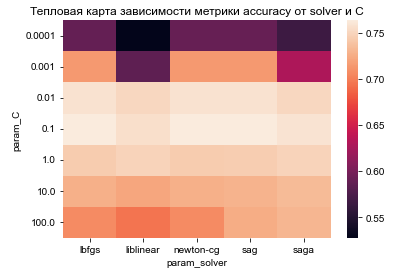

In [7]:
# визуализируем результаты кросс-валидации
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)})

Тепловая карта показывает, что лучшие значения параметра C лежат в области 0.005-0.05 для всех рассмотренных алгоритмов.

In [8]:
# подбор гиперпараметров с применением RandomizedSearchCV
param_distributions = [
                {'penalty': ['l2'] , # тип регуляризации
                'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
                'C': [10**n for n in range(-4, 3)]}, # уровень силы регурялизации
                {'penalty': ['l1', 'l2'] ,
                'solver': ['liblinear', 'saga'],
                'C': [10**n for n in range(-4, 3)]}
]
# применим  cross validation с количеством фолдов N_SPLITS
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER), 
    param_distributions=param_distributions, 
    cv=skf, 
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(random_search.score(X_test, y_test)))
y_test_rs_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_rs_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.25 s
Wall time: 3min 36s
accuracy на тестовом наборе: 0.760
f1_score на тестовом наборе: 0.786
Наилучшие значения гиперпараметров: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


RandomizedSearchCV показал f1_score на тестовой выборке аналогичный GridSearchCV, при этом время оптимизации - в два раза меньше.

In [9]:
# так задать пространство гиперпараметров для Hyperopt не получилось - ругается на 'DuplicateLabel: penalty'
# space = hp.choice('classifier_opt', [
#     {
#         'penalty_1': hp.choice('penalty', ['l2', None]),
#         'solver_1': hp.choice('solver', ['lbfgs', 'sag', 'newton-cg']),
#         'C_1': hp.loguniform('C', low=-4*np.log(10), high=2*np.log(10))
#     },
#     {
#         'penalty_2': hp.choice('penalty', ['l1', 'l2']),
#         'solver_2': hp.choice('solver', ['liblinear', 'saga']),
#         'C_2': hp.loguniform('C', low=-4*np.log(10), high=2*np.log(10))
#     },
# ])

In [10]:
# функция для подбора гиперпараметров с применением Hyperopt
def hyperopt_lr(params, X=X_train, y=y_train, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    model = linear_model.LogisticRegression(**params, max_iter=MAX_ITER, random_state=random_state)
    model.fit(X, y)
    # применим  cross validation с количеством фолдов, переданным в функцию
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()
    return {'loss': -score, 'params': params, 'status': STATUS_OK}

In [11]:
%%time
# подбор гиперпараметров с применением Hyperopt - алгоритмы, работающие с l2-регуляризацией
space_l2 = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['lbfgs', 'sag', 'newton-cg']),
    'C': hp.loguniform('C', low=-4*np.log(10), high=2*np.log(10))
}
trials_l2 = Trials() # логирование результатов
best_l2 = fmin(hyperopt_lr, # функция 
          space=space_l2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм байесовской оптимизации TPE
          max_evals=10, # максимальное количество итераций
          trials=trials_l2,
          rstate=np.random.default_rng(RANDOM_STATE)
         )
print("Наилучшие значения гиперпараметров {}".format(trials_l2.best_trial['result']['params']))

 70%|███████   | 7/10 [00:55<00:39, 13.22s/trial, best loss: -0.7767721913975502]

c:\Users\Marina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 10/10 [02:25<00:00, 14.57s/trial, best loss: -0.7846291307165227]
Наилучшие значения гиперпараметров {'C': 0.07644393107925136, 'penalty': 'l2', 'solver': 'newton-cg'}
CPU times: total: 1min 7s
Wall time: 2min 25s


Оптимизатор вернул warnings, говорящие, что среди случайных наборов гиперпараметров некоторые дают плохо сходящиеся модели. Т.к. эти комбинации гиперпараметров нам не интересны, нет смысла еще увеличивать max_iter и, следовательно, время расчета, только для того чтобы выводилось меньше warnings. Оставляем как есть.

In [12]:
# Модель с гиперпараметрами, подобранными Hyperopt на первой комбинации 
log_reg_hyp_l2 = linear_model.LogisticRegression(penalty=trials_l2.best_trial['result']['params']['penalty'],
                                                solver=trials_l2.best_trial['result']['params']['solver'],
                                                C=trials_l2.best_trial['result']['params']['C'],
                                                max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_hyp_l2.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_hyp_l2.score(X_test, y_test)))
y_test_pred = log_reg_hyp_l2.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.758
f1_score на тестовом наборе: 0.784


In [28]:
%%time
# добавим еще 5 итераций
best_l2 = fmin(hyperopt_lr, # функция 
          space=space_l2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм байесовской оптимизации TPE
          max_evals=15, # максимальное количество итераций
          trials=trials_l2,
          rstate=np.random.default_rng(RANDOM_STATE)
         )
print("Наилучшие значения гиперпараметров {}".format(trials_l2.best_trial['result']['params']))
log_reg_hyp_l2 = linear_model.LogisticRegression(penalty=trials_l2.best_trial['result']['params']['penalty'],
                                                solver=trials_l2.best_trial['result']['params']['solver'],
                                                C=trials_l2.best_trial['result']['params']['C'],
                                                max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_hyp_l2.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_hyp_l2.score(X_test, y_test)))
y_test_pred = log_reg_hyp_l2.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 15/15 [00:26<00:00,  5.39s/trial, best loss: -0.7846291307165227]
Наилучшие значения гиперпараметров {'C': 0.07644393107925136, 'penalty': 'l2', 'solver': 'newton-cg'}
accuracy на тестовом наборе: 0.758
f1_score на тестовом наборе: 0.784


Cмотрим другой набор penalty и solver. 

К сожалению, у современных оптимизаторов не нашла возможности передавать независимые несовместимые комбинации параметров. Пришлось запускать оптимизаторы два раза. Если вы знаете более компактное решение - дайте плз ссылку в комментариях к проверке.

In [13]:
%%time
# подбор гиперпараметров с применением Hyperopt - алгоритмы, работающие с l1 и l2-регуляризацией
space_l12 = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'C': hp.loguniform('C', low=-4*np.log(10), high=2*np.log(10))
}
trials_l12 = Trials() # логирование результатов
best_l12 = fmin(hyperopt_lr, # функция 
          space=space_l12, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм байесовской оптимизации TPE
          max_evals=10, # максимальное количество итераций
          trials=trials_l12,
          rstate=np.random.default_rng(RANDOM_STATE)
         )
print("Наилучшие значения гиперпараметров {}".format(trials_l12.best_trial['result']['params']))

 10%|█         | 1/10 [00:01<00:12,  1.42s/trial, best loss: -0.7750601521014476]

c:\Users\Marina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 6/10 [01:51<00:41, 10.41s/trial, best loss: -0.7820011766665956]

c:\Users\Marina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 10/10 [03:38<00:00, 21.88s/trial, best loss: -0.7820011766665956]
Наилучшие значения гиперпараметров {'C': 0.44616446018249856, 'penalty': 'l1', 'solver': 'saga'}
CPU times: total: 1min 48s
Wall time: 3min 38s


In [14]:
# Модель с гиперпараметрами, подобранными Hyperopt на второй комбинации 
log_reg_hyp_l12 = linear_model.LogisticRegression(penalty=trials_l12.best_trial['result']['params']['penalty'],
                                                solver=trials_l12.best_trial['result']['params']['solver'],
                                                C=trials_l12.best_trial['result']['params']['C'],
                                                max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_hyp_l12.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_hyp_l12.score(X_test, y_test)))
y_test_pred = log_reg_hyp_l12.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.752
f1_score на тестовом наборе: 0.776


c:\Users\Marina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Оптимизация Hyperopt после увеличения количества итераций до 30 (не вошло в финальный ноутбук) показала параметры, при которых f1_score на кросс-валидации тренировочных данных достигает 0.792, причем к одинаковым параметрам C и penalty сошлись разные алгоритмы. При этом на тестовых данных результат на 1 тысячную хуже, чем у первых двух методов.

Таким образом, на тестовом наборе модель с гиперпараметрами, выбранными Hyperopt на обучающей выборке за аналогичное время, показала не лучший, но сравнимый результат.

In [6]:
# функция для подбора гиперпараметров с применением Optuna - алгоритмы, работающие с l2-регуляризацией
def optuna_lr_l2(trial):
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    C = trial.suggest_float('C', low=10**(-4), high=10**2, log=True)
    # создаем модель
    model = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver, 
                                            max_iter = MAX_ITER, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    # применим  cross validation с количеством фолдов N_SPLITS
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()
    return score

In [7]:
%%time
# cоздаем объект исследования
study_l2 = optuna.create_study(study_name="LogisticRegression_l2", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_l2.optimize(optuna_lr_l2, n_trials=10)
print("Лучшие значения гиперпараметров {}".format(study_l2.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_l2.best_value))

[I 2023-04-28 23:57:59,553] A new study created in memory with name: LogisticRegression_l2
[I 2023-04-28 23:58:07,164] Trial 0 finished with value: 0.7917699664491561 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.027581013918536814}. Best is trial 0 with value: 0.7917699664491561.
[I 2023-04-28 23:58:10,111] Trial 1 finished with value: 0.7228939825749776 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.00011450034151960255}. Best is trial 0 with value: 0.7917699664491561.
[I 2023-04-28 23:58:14,812] Trial 2 finished with value: 0.7831643487755958 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.006684983569042624}. Best is trial 0 with value: 0.7917699664491561.
[I 2023-04-28 23:59:42,003] Trial 3 finished with value: 0.76794467091192 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 4.340733825486745}. Best is trial 0 with value: 0.7917699664491561.
[I 2023-04-28 23:59:57,187] Trial 4 finished with value: 0.772604647402827 and parameter

Лучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.07543768360786529}
f1_score на обучающем наборе: 0.793
CPU times: total: 50.8 s
Wall time: 2min 27s


In [17]:
# Модель с гиперпараметрами, подобранными Optuna на первой комбинации
log_reg_opt_l2 = linear_model.LogisticRegression(**study_l2.best_params, max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_opt_l2.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_opt_l2.score(X_test, y_test)))
y_test_pred = log_reg_opt_l2.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.750
f1_score на тестовом наборе: 0.776


In [29]:
%%time
# добавим еще 10 итераций
study_l2.optimize(optuna_lr_l2, n_trials=10)
print("Лучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study.best_value))
log_reg_opt_l2 = linear_model.LogisticRegression(**study_l2.best_params, max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_opt_l2.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_opt_l2.score(X_test, y_test)))
y_test_pred = log_reg_opt_l2.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-04-28 15:16:22,306] Trial 10 finished with value: 0.7883784736559045 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.01238757377679795}. Best is trial 10 with value: 0.7883784736559045.
[I 2023-04-28 15:16:31,385] Trial 11 finished with value: 0.7865508062919087 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.009019588702176324}. Best is trial 10 with value: 0.7883784736559045.
[I 2023-04-28 15:16:43,524] Trial 12 finished with value: 0.7883232288670786 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.014262114093494777}. Best is trial 10 with value: 0.7883784736559045.
[I 2023-04-28 15:16:57,750] Trial 13 finished with value: 0.7913166813155883 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.019189556176198698}. Best is trial 13 with value: 0.7913166813155883.
[I 2023-04-28 15:17:15,523] Trial 14 finished with value: 0.7920591499596107 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.026490186563768555}. Best is trial 14 with val

accuracy на тестовом наборе: 0.755
f1_score на тестовом наборе: 0.783


In [8]:
# функция для подбора гиперпараметров с применением Optuna - алгоритмы, работающие с l1 и l2-регуляризацией
def optuna_lr_l12(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', low=10**(-4), high=10**2, log=True)
    # создаем модель
    model = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver, 
                                            max_iter = MAX_ITER, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    # применим  cross validation с количеством фолдов N_SPLITS
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()
    return score

In [9]:
%%time
# cоздаем объект исследования
study_l12 = optuna.create_study(study_name="LogisticRegression_l12", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_l12.optimize(optuna_lr_l12, n_trials=10)
print("Лучшие значения гиперпараметров {}".format(study_l12.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_l12.best_value))

[I 2023-04-29 00:01:11,101] A new study created in memory with name: LogisticRegression_l12
[I 2023-04-29 00:01:12,091] Trial 0 finished with value: 0.789856210528344 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.01729782679893228}. Best is trial 0 with value: 0.789856210528344.
[I 2023-04-29 00:01:35,815] Trial 1 finished with value: 0.7916704315236056 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.031030354407234166}. Best is trial 1 with value: 0.7916704315236056.
[I 2023-04-29 00:01:36,431] Trial 2 finished with value: 0.0 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.0002671214727903373}. Best is trial 1 with value: 0.7916704315236056.
[I 2023-04-29 00:01:37,303] Trial 3 finished with value: 0.7808710616296042 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.0766174469239749}. Best is trial 1 with value: 0.7916704315236056.
[I 2023-04-29 00:01:38,730] Trial 4 finished with value: 0.7856977192099446 and parameters: {'pe

Лучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.031030354407234166}
f1_score на обучающем наборе: 0.792
CPU times: total: 1min 36s
Wall time: 3min 57s


In [20]:
# Модель с гиперпараметрами, подобранными Optuna на второй комбинации
log_reg_opt_l12 = linear_model.LogisticRegression(**study_l12.best_params, max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_opt_l12.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_opt_l12.score(X_test, y_test)))
y_test_pred = log_reg_opt_l2.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.756
f1_score на тестовом наборе: 0.776


In [30]:
%%time
# добавим еще 10 итераций
study_l12.optimize(optuna_lr_l12, n_trials=10)
print("Лучшие значения гиперпараметров {}".format(study_l12.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_l12.best_value))
log_reg_opt_l12 = linear_model.LogisticRegression(**study_l12.best_params, max_iter = MAX_ITER, random_state=RANDOM_STATE)
log_reg_opt_l12.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg_opt_l12.score(X_test, y_test)))
y_test_pred = log_reg_opt_l12.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-04-28 15:22:23,099] Trial 10 finished with value: 0.7272803424507124 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.00013591342127446145}. Best is trial 4 with value: 0.7945064842997239.
[I 2023-04-28 15:22:23,923] Trial 11 finished with value: 0.7756040093305521 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.002502310510217083}. Best is trial 4 with value: 0.7945064842997239.
[I 2023-04-28 15:22:24,890] Trial 12 finished with value: 0.7765971125143374 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0032029904599568185}. Best is trial 4 with value: 0.7945064842997239.
[I 2023-04-28 15:22:28,122] Trial 13 finished with value: 0.7675948423746227 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 5.3393672828771415}. Best is trial 4 with value: 0.7945064842997239.
[I 2023-04-28 15:22:35,650] Trial 14 finished with value: 0.7734115604222948 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.0023638872090087026}. Best i

accuracy на тестовом наборе: 0.756
f1_score на тестовом наборе: 0.784


Optuna как и Hyperopt еще увеличивает значение f1_score на тренировочных данных, при этом на тестовых данных показывает результат, аналогичный предыдущим методам.

In [21]:
optuna.visualization.is_available()

True

In [31]:
optuna.visualization.plot_optimization_history(study_l2, target_name="f1_score")

In [32]:
optuna.visualization.plot_optimization_history(study_l12, target_name="f1_score")

Обучение идет в сторону максимизации f1_score

In [33]:
optuna.visualization.plot_param_importances(study_l2, target_name="f1_score")

In [34]:
optuna.visualization.plot_param_importances(study_l12, target_name="f1_score")

In [35]:
optuna.visualization.plot_contour(study_l2, params=["C", "solver"], target_name="f1_score")

In [36]:
optuna.visualization.plot_contour(study_l12, params=["C", "solver"], target_name="f1_score")

In [37]:
optuna.visualization.plot_contour(study_l12, params=["C", "penalty"], target_name="f1_score")

Как и тепловая карта GridSearch, визуализация Optuna показывает оптимальный интервал параметра C, аналогичный для всех рассмотренных алгоритмов. Видимо, такая простая структура оптимальной области гиперпараметров и позволила получить лучший результат на тестовых данных за более короткое время простым методом GridSearch.